# Baseline results: Single visit models  

## Case1: train on entire ses2 subject with *only* single visit data. Test on ses2 and ses3 scans of subject with two visit data.
## Case2: train on train_metadata subset of ses2 data from subjects with two visits. Test on ses2 and ses3 scans from test_metadata subjects. 

In [1]:
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
results_dir = "/home/nikhil/projects/brain_changes/brain-diff/results/baseline_models/"
summary_results_dir = "/home/nikhil/projects/brain_changes/brain-diff/results/summary/"


## Case1 results
- Train on entire ses2 subject with *only* single visit data.
- Test on ses2 and ses3 scans of subject with two visit data.

In [3]:
full_ses_dir = f"{results_dir}full_ses2/freesurfer_age_prediction_full_session_2_2021-11-12T17:33:37.275174"

In [4]:
ses2_y_true_df = pd.read_csv(f"{full_ses_dir}/y_true_session_2.csv")
ses3_y_true_df = pd.read_csv(f"{full_ses_dir}/y_true_session_3.csv")

ses2_preds_df = pd.read_csv(f"{full_ses_dir}/predictions_session_2.csv")
ses3_preds_df = pd.read_csv(f"{full_ses_dir}/predictions_session_3.csv")
ses2_preds_df = ses2_preds_df.rename(columns={"0":"brainage_at_ses2"})
ses3_preds_df = ses3_preds_df.rename(columns={"0":"brainage_at_ses3"})

ses2_df = pd.merge(ses2_y_true_df,ses2_preds_df, on="eid")
ses3_df = pd.merge(ses3_y_true_df,ses3_preds_df, on="eid")

perf_df = pd.merge(ses2_df,ses3_df,on="eid")
perf_df["model"] = "GradBoost_large"
perf_df["baseline_err"] = perf_df["brainage_at_ses2"] - perf_df["age_at_ses2"]
perf_df["followup_err"] = perf_df["brainage_at_ses3"] - perf_df["age_at_ses3"]

perf_df["brainage_delta"] = perf_df["brainage_at_ses3"] - perf_df["brainage_at_ses2"]
perf_df["chronoage_delta"] = perf_df["age_at_ses3"] - perf_df["age_at_ses2"]
perf_df["delta_err"] = perf_df["brainage_delta"] - perf_df["chronoage_delta"]

perf_df["Benjamin_Button"] = perf_df["brainage_at_ses3"] < perf_df["brainage_at_ses2"]

n_BBs = perf_df["Benjamin_Button"].sum()
print(f"n BBs: {n_BBs} ({100*n_BBs/len(perf_df):4.3f}%)")

perf_df_melt = perf_df.melt(id_vars=["eid", "model", "age_at_ses2",	"brainage_at_ses2",	"age_at_ses3", "brainage_at_ses3", "chronoage_delta", "brainage_delta"], 
              value_vars=['baseline_err', 'followup_err', 'delta_err'],
              var_name='err_type', value_name='error')

n BBs: 1328 (41.487%)


chronoage_delta  err_type    
1.0              baseline_err    4.828480
                 delta_err       2.977286
                 followup_err    4.604181
2.0              baseline_err    4.979275
                 delta_err       2.622187
                 followup_err    5.104524
3.0              baseline_err    4.921461
                 delta_err       3.198952
                 followup_err    4.967142
4.0              baseline_err    6.318118
                 delta_err       4.561853
                 followup_err    5.516348
5.0              baseline_err    7.967288
                 delta_err       4.921352
                 followup_err    5.136470
6.0              baseline_err    8.234657
                 delta_err       5.090667
                 followup_err    5.799292
7.0              baseline_err    9.151685
                 delta_err       7.306017
                 followup_err    6.519824
Name: abs_error, dtype: float64


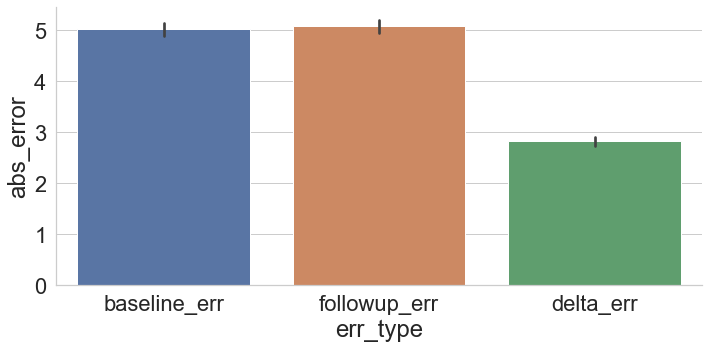

In [5]:
plot_df = perf_df_melt.copy()
plot_df["abs_error"] = np.abs(plot_df["error"]) 
print(plot_df.groupby(["chronoage_delta","err_type"]).mean()["abs_error"])

sns.set(font_scale=2)
with sns.axes_style("whitegrid"):
    g = sns.catplot(x="err_type",y="abs_error", kind="bar", data=plot_df,aspect=2)

## Save summary results

In [6]:
save_summary_results = False
if save_summary_results:
    perf_df_melt.to_csv(f"{summary_results_dir}baseline_model_single_visit_train_full_ses2_test_two_visit_subset.csv")

## Case2 results
- Train on train_metadata subset of ses2 data from subjects with two visits. 
- Test on ses2 and ses3 scans from test_metadata subjects. 

In [7]:
two_visit_subset_dir = f"{results_dir}two_visit_subset/"
ses2_subdir = f"{two_visit_subset_dir}freesurfer_age_prediction_2021-11-10T15:34:26.163051"
ses3_subdir = f"{two_visit_subset_dir}freesurfer_age_prediction_2021-11-10T16:00:20.678190"

In [8]:
ses2_y_true_df = pd.read_csv(f"{ses2_subdir}/y_true.csv")
ses3_y_true_df = pd.read_csv(f"{ses3_subdir}/y_true.csv")

ses2_preds_df = pd.read_csv(f"{ses2_subdir}/predictions.csv")
ses3_preds_df = pd.read_csv(f"{ses3_subdir}/predictions.csv")
ses2_preds_df = ses2_preds_df.rename(columns={"0":"brainage_at_ses2"})
ses3_preds_df = ses3_preds_df.rename(columns={"0":"brainage_at_ses3"})

ses2_df = pd.merge(ses2_y_true_df,ses2_preds_df, on="eid")
ses3_df = pd.merge(ses3_y_true_df,ses3_preds_df, on="eid")

perf_df = pd.merge(ses2_df,ses3_df,on="eid")
perf_df["model"] = "GradBoost_small"

perf_df["baseline_err"] = perf_df["brainage_at_ses2"] - perf_df["age_at_ses2"]
perf_df["followup_err"] = perf_df["brainage_at_ses3"] - perf_df["age_at_ses3"]

perf_df["brainage_delta"] = perf_df["brainage_at_ses3"] - perf_df["brainage_at_ses2"]
perf_df["chronoage_delta"] = perf_df["age_at_ses3"] - perf_df["age_at_ses2"]
perf_df["delta_err"] = perf_df["brainage_delta"] - perf_df["chronoage_delta"]

perf_df["Benjamin_Button"] = perf_df["brainage_at_ses3"] < perf_df["brainage_at_ses2"]

n_BBs = perf_df["Benjamin_Button"].sum()
print(f"n BBs: {n_BBs} ({100*n_BBs/len(perf_df):4.3f}%)")

perf_df_melt = perf_df.melt(id_vars=["eid", "model", "age_at_ses2",	"brainage_at_ses2",	"age_at_ses3", "brainage_at_ses3", "chronoage_delta", "brainage_delta"], 
              value_vars=['baseline_err', 'followup_err', 'delta_err'],
              var_name='err_type', value_name='error')

n BBs: 443 (41.911%)


## Plots

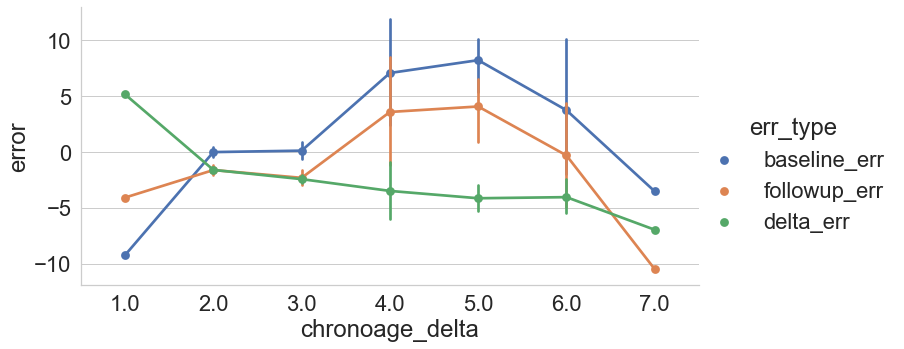

In [9]:
plot_df = perf_df_melt.copy()
sns.set(font_scale=2)
with sns.axes_style("whitegrid"):
    # fig, ax = plt.subplots(figsize=(20,10))
    g = sns.catplot(x="chronoage_delta",y="error", hue="err_type", kind="point", data=plot_df,aspect=2)

chronoage_delta  err_type    
1.0              baseline_err     9.228598
                 delta_err        5.147178
                 followup_err     4.081420
2.0              baseline_err     5.154600
                 delta_err        2.405464
                 followup_err     5.411493
3.0              baseline_err     4.874795
                 delta_err        2.959662
                 followup_err     5.282505
4.0              baseline_err     7.166418
                 delta_err        3.740933
                 followup_err     6.295865
5.0              baseline_err     8.928791
                 delta_err        4.143113
                 followup_err     5.708794
6.0              baseline_err     8.456662
                 delta_err        4.044197
                 followup_err     6.821430
7.0              baseline_err     3.528754
                 delta_err        6.961520
                 followup_err    10.490274
Name: abs_error, dtype: float64


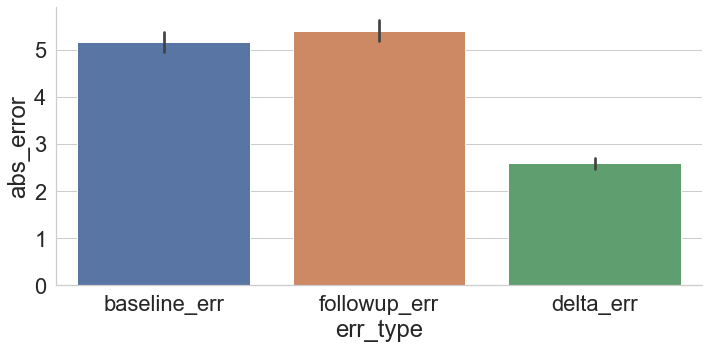

In [10]:
plot_df = perf_df_melt.copy()
plot_df["abs_error"] = np.abs(plot_df["error"]) 
print(plot_df.groupby(["chronoage_delta","err_type"]).mean()["abs_error"])

sns.set(font_scale=2)
with sns.axes_style("whitegrid"):
    g = sns.catplot(x="err_type",y="abs_error", kind="bar", data=plot_df,aspect=2)

In [11]:
save_summary_results = False
if save_summary_results:
    perf_df_melt.to_csv(f"{summary_results_dir}baseline_model_single_visit_train_two_visit_subset_test_two_visit_subset.csv")